In [32]:
from salad.serialize import read
from pathlib import Path
from functools import lru_cache
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.table
import numpy as np

In [95]:

def load_results(search_prefix, detector, snr, time_type, search_label, step="filtered"):
    # get recoveries at a certain step
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    return read(list(p.rglob(f"{step}.pkl"))[0])


def recoveries(search_prefix, detector, snr, time_type, search_label, step="filtered"):
    # get recoveries at a certain step
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    return read(list(p.rglob(f"{step}_recovery.pkl"))[0])

def was_found(fake_recovery, threshold=15):
    ret = []
    for o in fake_recovery:
        f = fake_recovery[o]
        found_points = False
        found_line = False
        n_points = 0
        n_lines = 0
        for c in f['points']:
            p = f['points'][c]
            precision = p['fake']/p['total']
            recall = p['fake']/f['catalog']['fake']
            if precision > 0.5:
                found_points = True
                n_points += 1
                
            if c in f['line']:
                l = f['line'][c]
                line_recovery = l['fake']/l['total']
                if precision > 0.5 and line_recovery > 0.5:
                    found_line = True
                    n_lines += 1
        
        ret.append(
            {
                "orbit": o,
                "found_points": found_points,
                "found_line": found_line,
                "points": f['catalog']['fake'],
                "n_points": n_points,
                "n_lines": n_lines,
                "fake_detection": f['catalog']['fake'],
                "fake_injection": f['catalog']['total'],
            }
        )
        
        if 'findable' in f['info']:
            ret[-1]['in_search'] = f['info']['findable']
        elif f['catalog']['total'] == 1:
            ret[-1]['in_search'] = False
            
            
    return astropy.table.Table(ret)

In [98]:
r = recoveries("new", 35, 3.0, "regular", "asteroid", step="deduplicated")
was_found(r)

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,in_search
int64,bool,bool,int64,int64,int64,int64,int64,bool
13983168,True,True,80,1,1,80,104,False
1632097,True,True,74,1,1,74,104,False
89549,False,False,1,0,0,1,104,False
2331695,True,True,66,1,1,66,104,False
10228593,False,False,1,0,0,1,24,True
2419828,False,False,17,0,0,17,104,False
11447771,False,False,16,0,0,16,104,True
13787198,False,False,19,0,0,19,104,False


In [99]:
search_prefix = "new"
detector = 1

f = []
for detector in range(1, 63):
    if detector in [2, 61]:
        continue
    fakes = read(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/fakes.pkl")
    f.append(fakes)
fakes = astropy.table.vstack(f)


mags = []
for g in fakes.group_by("ORBITID").groups:
    mags.append(
        {
            "orbit": g[0]['ORBITID'],
            "mag": np.median(g['MAG'])
        }
    )
mags = astropy.table.Table(mags)

In [101]:
x = np.arange(1, 25)


y_mag = []
y_num = []

for snr in [5.0, 4.0, 3.0]:
    y_mag.append([])
    y_num.append([])

    for detector in range(1, 63):
        if detector in [2, 61]:
            continue
        try:
            r = recoveries("new", detector, snr, "regular", "asteroid", step="deduplicated")
        except:
            print(snr, detector)
        y_mag[-1].append([])
        y_num[-1].append([])
        for n in x:
            for k in r:
                for c in list(r[k]['points'].keys()):
                    if r[k]['points'][c]['total'] < n:
                        r[k]['points'].pop(c)

            t = astropy.table.join(was_found(r), mags, keys=['orbit'])
            _t = t[t['found_points']]
            if len(_t) > 0:
                y_mag[-1][-1].append(_t['mag'].max())
                y_num[-1][-1].append(len(_t))


In [106]:
y_num[0].index([])

9

In [122]:
while True:
    try:
        y_mag[0].pop(y_mag[0].index([]))
    except:
        break

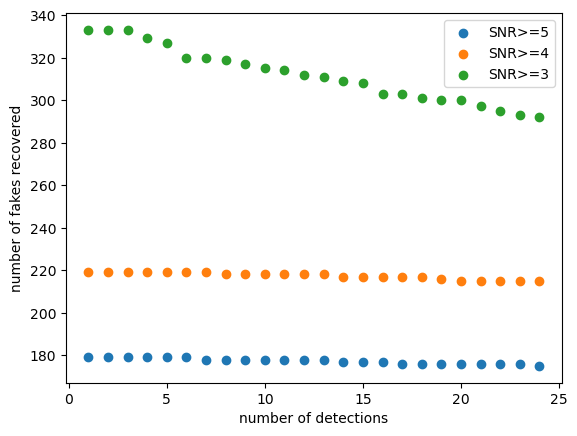

In [125]:
plt.scatter(x, np.array(y_num[0]).sum(axis=0), label="SNR>=5")
plt.scatter(x, np.array(y_num[1]).sum(axis=0), label="SNR>=4")
plt.scatter(x, np.array(y_num[2]).sum(axis=0), label="SNR>=3")
plt.legend()
plt.xlabel("number of detections")
plt.ylabel("number of fakes recovered")
plt.show()

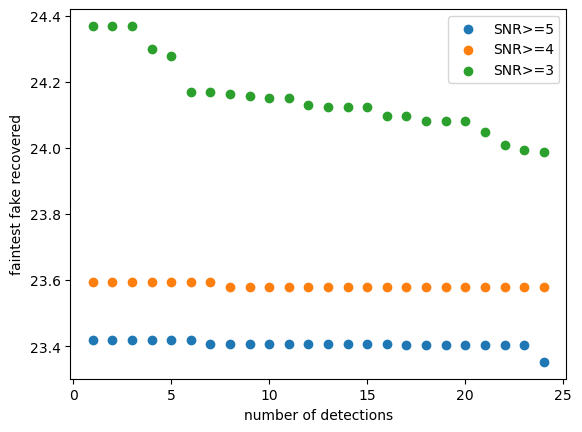

In [126]:
plt.scatter(x, np.array(y_mag[0]).max(axis=0), label="SNR>=5")
plt.scatter(x, np.array(y_mag[1]).max(axis=0), label="SNR>=4")
plt.scatter(x, np.array(y_mag[2]).max(axis=0), label="SNR>=3")
plt.xlabel("number of detections")
plt.ylabel("faintest fake recovered")
plt.legend()
plt.show()

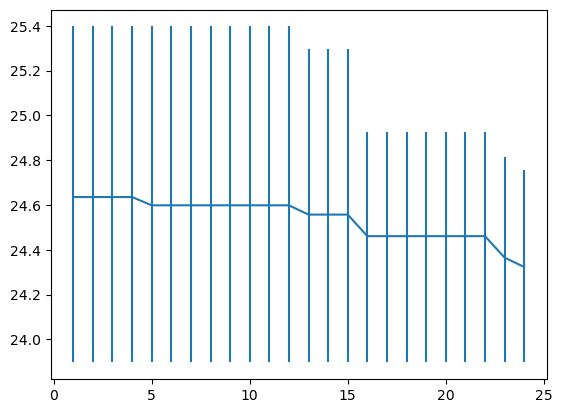

In [80]:
m = np.array(y_mag).mean(axis=0)
l = m - np.array(y_mag).min(axis=0)
u = np.array(y_mag).max(axis=0) - m
plt.errorbar(x, m, yerr=[l, u])
plt.show()

In [17]:
was_found(r)

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,in_search
int64,bool,bool,int64,int64,int64,int64,int64,bool
13039521,False,False,1,0,0,1,104,True
5182786,False,False,1,0,0,1,104,False
10564514,False,False,0,0,0,0,21,True
2732908,False,False,0,0,0,0,104,False
14621325,True,True,85,1,1,85,104,True
10053463,False,False,3,0,0,3,104,True
6009903,False,False,0,0,0,0,104,False
13776855,True,True,72,1,1,72,104,True
4279478,False,False,11,0,0,11,104,False
